In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def read_file(year):
    PATH = f'imbank_customer_data/iMBANK_CUSTOMER_DATA_{year}(K-DigitalTraining).csv'
    df = pd.read_csv(PATH, encoding='euc-kr', usecols=['기준년월', '고객ID', '연령대'])
    df = df.sort_values(by='기준년월', ascending=True).reset_index(drop=True)
    return df
    
CS_2021 = read_file(2021)

In [3]:
def read_file1(year):
    PATH = f'imbank_card_data/iMBANK_CARD_DATA_{year}(K-DigitalTraining).csv'
    df = pd.read_csv(PATH, encoding='euc-kr', usecols=['거래년월', '고객ID'])
    df = df.sort_values(by='거래년월', ascending=True).reset_index(drop=True)
    return df
C_2021 = read_file1(2021)

In [4]:
# 거래년월이 202212 이전인 데이터 필터링 -> 12월 안가져가도 되나???? 
filtered_data = C_2021[C_2021['거래년월'] < 202212]

# 마지막 거래년월 찾기
last_transaction = filtered_data.groupby('고객ID')['거래년월'].max().reset_index()
last_transaction.columns = ['고객ID', '마지막 거래년월']
last_transaction.tail()


,고객ID,마지막 거래년월
769848,9999918728,202112
769849,9999933174,202109
769850,9999972286,202101
769851,9999981183,202112
769852,9999998161,202112


In [5]:
# 고객ID 기준 Data_frame merge
merge_card_2021 = pd.merge(C_2021, last_transaction, on='고객ID', how='left')
merge_card_2021.tail(15)

,거래년월,고객ID,마지막 거래년월
60672627,202112,3177078879,202112
60672628,202112,3205011838,202112
60672629,202112,3055061788,202112
60672630,202112,2931907302,202112
60672631,202112,2950007638,202112
60672632,202112,2914424833,202112
60672633,202112,4116127380,202112
60672634,202112,9580341295,202112
60672635,202112,9444540701,202112
60672636,202112,7938809932,202112


In [6]:
# 거래이후 소요시간 계산 
current_year_month = 202111
merge_card_2021['거래이후소요기간'] = ((current_year_month // 100 - merge_card_2021['마지막 거래년월'] // 100) * 12 +
                                        (current_year_month % 100 - merge_card_2021['마지막 거래년월'] % 100))

In [7]:
# 11월 이전 데이터만 추출 -> 예측 위함이라 21년 필요 없을듯 ..? 
# new_card_2021 = merge_card_2021[merge_card_2021['거래년월'] < 202312]
# new_card_2021.tail()

In [8]:
# 거래년월 컬럼 삭제 
new_card_2021 = merge_card_2021.drop(columns=['거래년월'])

In [9]:
#마지막컬럼 남기고 중복 제거 -> 거래이후소요기간은 동일 값이라 정렬 필요 없음
new_card_2021 = new_card_2021.drop_duplicates(subset='고객ID', keep='last').reset_index(drop=True)
new_card_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769853 entries, 0 to 769852
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   고객ID      769853 non-null  int64
 1   마지막 거래년월  769853 non-null  int64
 2   거래이후소요기간  769853 non-null  int64
dtypes: int64(3)
memory usage: 17.6 MB


In [10]:
# 중복 확인코드
# dupl = new_card_2021['고객ID'].duplicated().any()
# if dupl:
#     print('중복')
# else:
#     print('중복아님')

In [11]:
# 이탈 여부 판단
new_card_2021['이탈여부'] = np.where(new_card_2021['거래이후소요기간'] > 1,'이탈', '유지')


In [12]:
new_card_2021.groupby(['이탈여부']).count()

,고객ID,마지막 거래년월,거래이후소요기간
이탈여부,,,
유지,645952,645952,645952
이탈,123901,123901,123901


In [13]:
# CS 데이터 기준년월컬럼 삭제 및 고객ID 중복 거거
CS_2021 = CS_2021.drop(columns='기준년월')

In [24]:
# card_2023 & CS_2023 merge
last = new_card_2021.merge(CS_2021, on=['고객ID'], how='left')
# 고객 ID 중복 거거
last = last.drop_duplicates(subset='고객ID', keep='last').reset_index(drop=True)
last.head()

,고객ID,마지막 거래년월,거래이후소요기간,이탈여부,연령대
0,5558279370,202101,10,이탈,30대
1,5971116803,202101,10,이탈,40대
2,3152683788,202101,10,이탈,50대
3,9812943452,202101,10,이탈,60대이상
4,4665400531,202101,10,이탈,20대


In [25]:
# 서머리 결과 DF 형태로 저장
summary = pd.DataFrame(last.groupby(['이탈여부','연령대'])['고객ID'].count())
summary = summary.reset_index()

In [26]:
# 유지와 이탈 고객의 전체 수
total유지 = summary[summary['이탈여부'] == '유지']['고객ID'].sum()
total이탈 = summary[summary['이탈여부'] == '이탈']['고객ID'].sum()

# 비율 계산
summary['비율'] = summary.apply(lambda row: row['고객ID'] / total유지 if row['이탈여부'] == '유지' else
                      (row['고객ID'] / total이탈 if row['이탈여부'] == '이탈' else 0), axis=1)

# 결과 출력
summary

,이탈여부,연령대,고객ID,비율
0,유지,10대미만,33176,0.052071
1,유지,20대,101843,0.159847
2,유지,30대,87462,0.137275
3,유지,40대,118453,0.185917
4,유지,50대,144677,0.227077
5,유지,60대이상,151517,0.237812
6,이탈,10대미만,5373,0.043757
7,이탈,20대,25465,0.207385
8,이탈,30대,21271,0.173229
9,이탈,40대,24469,0.199274


In [27]:
# 중복 확인
dupl = new_summary['고객ID'].duplicated().any()
if dupl:
    print('중복')
else:
    print('중복아님')

중복아님


In [19]:
# 시각화 그리기 한글폰트 가가
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='white')

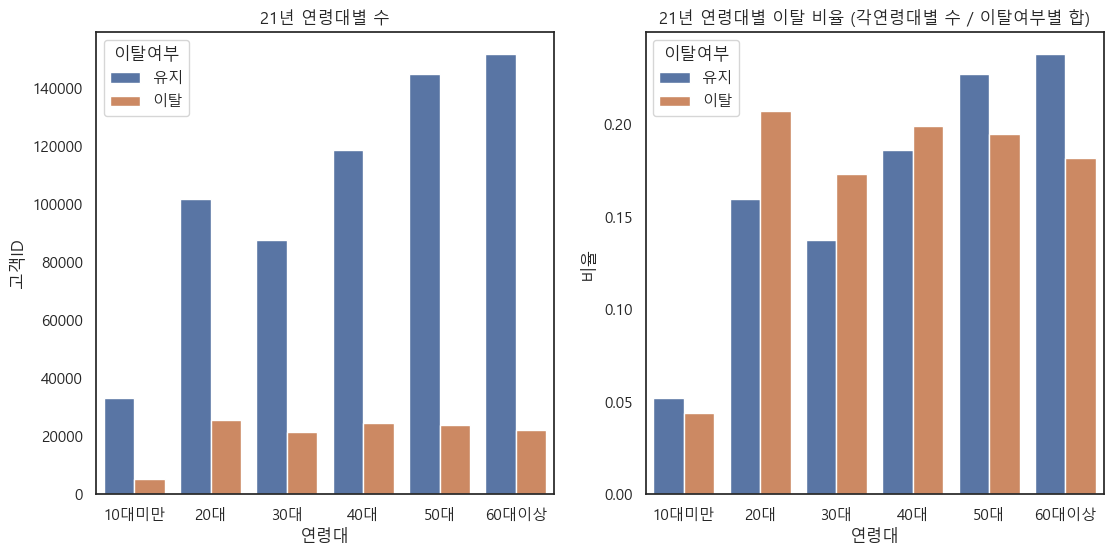

In [29]:
fig, ax = plt.subplots(figsize = (13,6), ncols=2)
sns.barplot(summary, x='연령대', y = '고객ID', hue='이탈여부', ax=ax[0])
sns.barplot(summary, x='연령대', y = '비율', hue='이탈여부', ax=ax[1])
ax[0].set_title('21년 연령대별 수', )
ax[1].set_title('21년 연령대별 이탈 비율 (각연령대별 수 / 이탈여부별 합)')
plt.show()

In [ ]:
last.to_csv('summary_2021.csv', index=False, encoding="utf-8-sig")